In [30]:
import kagglehub
path = kagglehub.dataset_download("yaraeslam/enhanced-road-segmentation-dataset")
print(path)

Using Colab cache for faster access to the 'enhanced-road-segmentation-dataset' dataset.
/kaggle/input/enhanced-road-segmentation-dataset


In [31]:
import os
voc_path = "/kaggle/input/enhanced-road-segmentation-dataset/VOC2007"

for root, dirs, files in os.walk(voc_path):
    print(root, dirs, files[:5])


/kaggle/input/enhanced-road-segmentation-dataset/VOC2007 ['SegmentationClassPNG', 'JPEGImages'] []
/kaggle/input/enhanced-road-segmentation-dataset/VOC2007/SegmentationClassPNG [] ['20220311151833_0060 024.png', '20220311153115_0023 051_rotation.png', '20220311151733_0060 003_color.png', '20220311144930_0060 022_color.png', '20220311151733_0060 002_rotation.png']
/kaggle/input/enhanced-road-segmentation-dataset/VOC2007/JPEGImages [] ['20220311153115_0023 043.jpg', '20220311151733_0060 012_flip.jpg', '0060_Image10_rotation.jpg', '20220311151733_0060 020_flip.jpg', '20220311144930_0060 131.jpg']


In [32]:
print(path)

/kaggle/input/enhanced-road-segmentation-dataset


In [36]:
# @title checking dataset
import os


voc_path = "/kaggle/input/enhanced-road-segmentation-dataset/VOC2007"

img_dir = os.path.join(voc_path, "JPEGImages")
mask_dir = os.path.join(voc_path, "SegmentationClassPNG")

image_ids = sorted([
    os.path.splitext(f)[0]
    for f in os.listdir(img_dir)
    if f.endswith(".jpg")
])

mask_ids = sorted([
    os.path.splitext(f)[0]
    for f in os.listdir(mask_dir)
    if f.endswith(".png")
])

# Keep only matching pairs
image_ids = sorted(list(set(image_ids) & set(mask_ids))) #filenames enforce matching

print("Total pairs:", len(image_ids))





Total pairs: 1496


In [37]:
# @title Train / validation / test split
from sklearn.model_selection import train_test_split

train_ids, temp_ids = train_test_split(
    image_ids, test_size=0.2, random_state=42
)

val_ids, test_ids = train_test_split(
    temp_ids, test_size=0.5, random_state=42
)

In [38]:
# @title build full paths
def build_paths(ids):
  # paths are bult using the same ID list
    images = [os.path.join(img_dir, f"{i}.jpg") for i in ids]
    masks  = [os.path.join(mask_dir, f"{i}.png") for i in ids]
    return images, masks

train_images, train_masks = build_paths(train_ids)
val_images, val_masks     = build_paths(val_ids)
test_images, test_masks   = build_paths(test_ids)

In [ ]:
# @title pipeline
import tensorflow as tf

IMG_SIZE = (256, 256)




def load_image_mask(img_path, mask_path):
    """ takes the path to an image file  and to its
    segmentation mask and returns them as tensors """
    img = tf.io.read_file(img_path) # opens the .jpg file
    img = tf.image.decode_jpeg(img, channels=3) # Converts it into a Tensor with 3 color channels (RGB)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0 #normalize image

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3) # (H,W,3) (each pixel has r,g,b values)
    mask = tf.image.resize(mask, IMG_SIZE, method="nearest") #Why "nearest"? Masks contain class IDs Other resize methods would create invalid values

    r = mask[:, :, 0] #takes the red channel of the image
    g = mask[:, :, 1] #takes the green channel of the image

    background = tf.cast((r == 0) & (g == 0), tf.uint8) 
    road       = tf.cast((r == 128) & (g == 0), tf.uint8)
    lane       = tf.cast((r == 0) & (g == 128), tf.uint8)

    # handle overlap explicitly
    lane = tf.cast((r == 0) & (g >= 128), tf.uint8)

    class_mask = background * 0 + road * 1 + lane * 2 #creates a single channel mask with class IDs (H,W)
    class_mask = tf.expand_dims(class_mask, axis=-1) #adds a channel dimension to the mask (H,W,1)

    return img, class_mask

def make_dataset(images, masks, batch_size=8, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((images, masks)) #Create dataset from filenames
    if shuffle:
        ds = ds.shuffle(100)
    ds = ds.map(
        lambda x, y: load_image_mask(x, y),
        num_parallel_calls=tf.data.AUTOTUNE # meaning --> TensorFlow, load several images at the same time to be faster.
    )
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE) # batch to train efficiently , and prefetch to prepare for the next patch (trainig efficiently as well)
    return ds




train_ds = make_dataset(train_images, train_masks)
val_ds   = make_dataset(val_images, val_masks, shuffle=False)


In [40]:
print(val_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>


In [41]:
import numpy as np

for _, mask in train_ds.take(1):
    print(np.unique(mask.numpy()))
#mask = mask / 255.0


[0 1 2]


In [42]:
for images, masks in train_ds.take(1):
    print(images.shape)
    print(masks.shape)


(8, 256, 256, 3)
(8, 256, 256, 1)


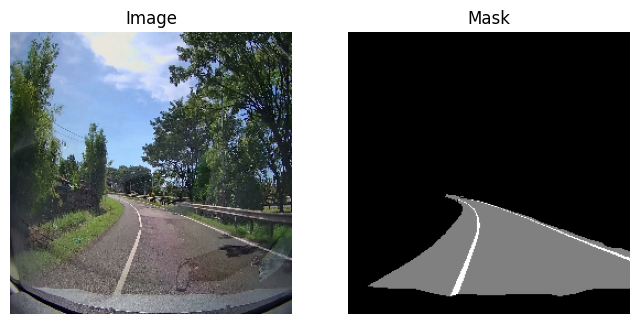

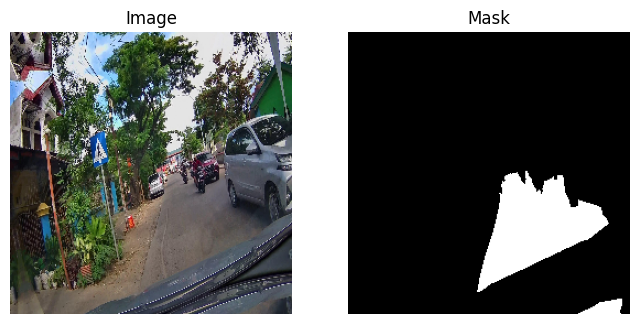

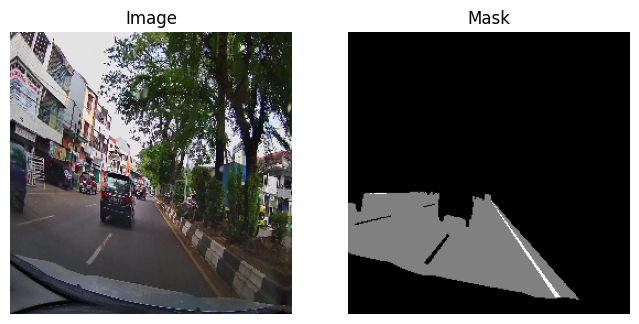

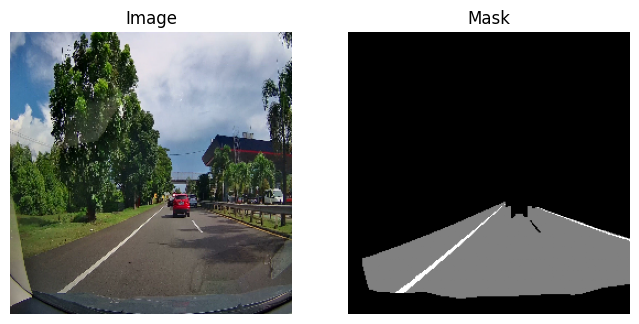

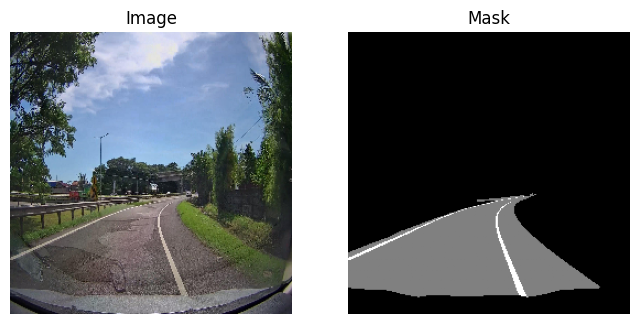

In [43]:
import matplotlib.pyplot as plt

for img, mask in train_ds.take(5):
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(img[0])
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask[0][:,:,0], cmap="gray")
    plt.title("Mask")
    plt.axis("off")


[[  0   0   0]
 [  0 128   0]
 [128   0   0]
 [128 128   0]]


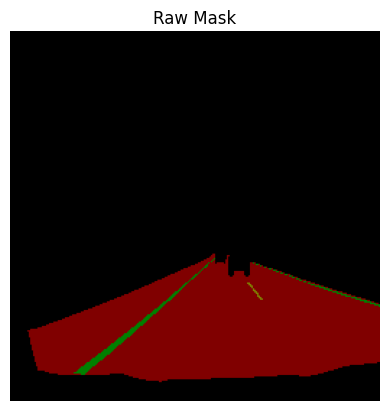

In [44]:
def debug_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.image.resize(mask, IMG_SIZE, method="nearest")

    return mask

for _, mask_path in zip(range(1), train_masks[:1]):
    m = debug_mask(mask_path)
    plt.imshow(m.numpy())
    plt.title("Raw Mask")
    plt.axis("off")

unique_vals = np.unique(tf.reshape(m, [-1, 3]).numpy(), axis=0)
print(unique_vals[:10])

In [ ]:

import matplotlib.pyplot as plt

for img, mask in train_ds.skip(750).take(6):
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(img[0])
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask[0][:,:,0], cmap="gray")
    plt.title("Mask")
    plt.axis("off")

(np.float64(-0.5), np.float64(2559.5), np.float64(1599.5), np.float64(-0.5))

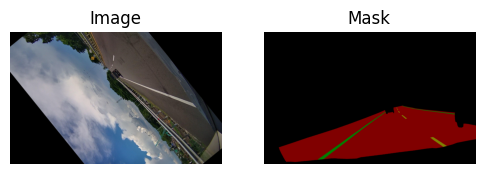

In [14]:
from PIL import Image

id = train_ids[700]

img = Image.open(os.path.join(img_dir, f"{id}.jpg"))
mask = Image.open(os.path.join(mask_dir, f"{id}.png"))

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(mask); plt.title("Mask"); plt.axis("off")


In [ ]:
# @title Architecture and helpers

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print("GPU available:", tf.config.list_physical_devices('GPU'))


def lane_iou(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)

    lane_true = tf.cast(y_true == 2, tf.float32)
    lane_pred = tf.cast(y_pred == 2, tf.float32)

    intersection = tf.reduce_sum(lane_true * lane_pred)
    union = tf.reduce_sum(lane_true) + tf.reduce_sum(lane_pred) - intersection

    return intersection / (union + 1e-6)


class MeanIoUFromLogits(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.squeeze(y_true, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)


def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Pretrained encoder
    encoder = ResNet50(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs
    )

    # Skip connections
    skips = [
        encoder.get_layer("conv1_relu").output,      # 128x128
        encoder.get_layer("conv2_block3_out").output,# 64x64
        encoder.get_layer("conv3_block4_out").output,# 32x32
        encoder.get_layer("conv4_block6_out").output # 16x16
    ]

    x = encoder.get_layer("conv5_block3_out").output # 8x8

    # Decoder
    for skip in reversed(skips):
        x = layers.Conv2DTranspose(256, 2, strides=2, padding="same")(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)


    #  FINAL UPSAMPLING: 128 → 256
    x = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    # outputs = layers.Conv2D(1, 1, activation="sigmoid")(x)
    NUM_CLASSES = 3  # background, road, lane

    outputs = layers.Conv2D(NUM_CLASSES, 1, activation="softmax")(x)


    model = models.Model(inputs, outputs)
    return model


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [46]:


model = build_unet(input_shape=(256, 256, 3))

# # Freeze encoder
# for layer in model.layers:
#     if isinstance(layer, tf.keras.Model):
#         layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[        tf.keras.metrics.SparseCategoricalAccuracy(name="acc"),
                     MeanIoUFromLogits(num_classes=3, name="miou"),
                     lane_iou]
)
model.summary()

checkpoint = ModelCheckpoint(
    "road_model_industryV1_myDATASET.keras",
    save_best_only=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint]
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 35,748,355 (136.37 MB)

 Trainable params: 35,695,235 (136.17 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - acc: 0.8963 - lane_iou: 0.0040 - loss: 0.2768 - miou: 0.4785 - val_acc: 0.6124 - val_lane_iou: 0.0000e+00 - val_loss: 1.2750 - val_miou: 0.2760
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 99s 658ms/step - acc: 0.9852 - lane_iou: 0.3813 - loss: 0.0395 - miou: 0.7656 - val_acc: 0.6577 - val_lane_iou: 0.0000e+00 - val_loss: 1.0006 - val_miou: 0.3026
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 102s 677ms/step - acc: 0.9895 - lane_iou: 0.5841 - loss: 0.0273 - miou: 0.8401 - val_acc: 0.8206 - val_lane_iou: 0.0000e+00 - val_loss: 0.4798 - val_miou: 0.3615
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 104s 694ms/step - acc: 0.9919 - lane_iou: 0.6717 - loss: 0.0209 - miou: 0.8748 - val_acc: 0.9268 - val_lane_iou: 0.0195 - val_loss: 0.2378 - val_miou: 0.5303
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 89s 591ms/step - acc: 0.9925 - lane_iou: 0.7051 - loss: 0.0189 - miou: 0.8866 - val_acc: 0.9232 - val_lane_iou: 0.1809 - val_loss: 0.3760 - val_miou: 0.5950
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


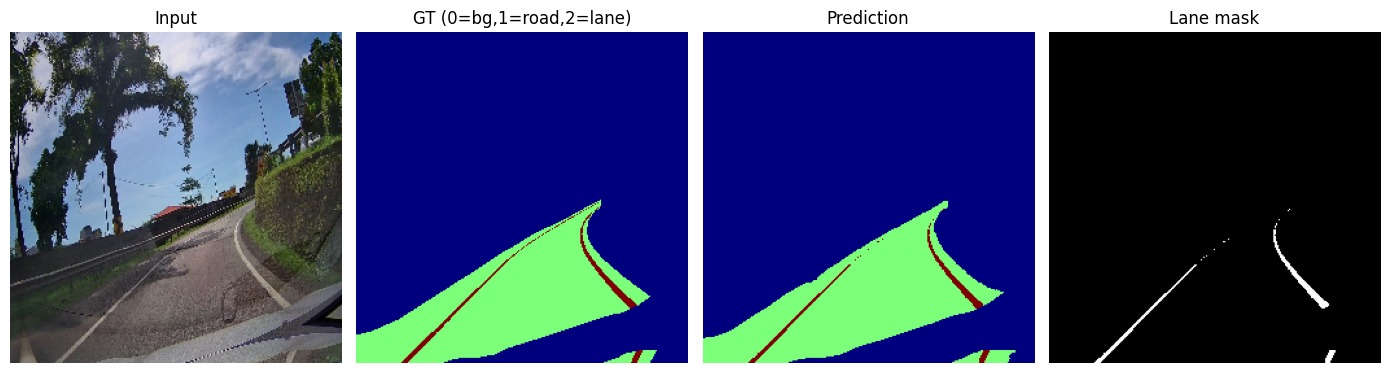

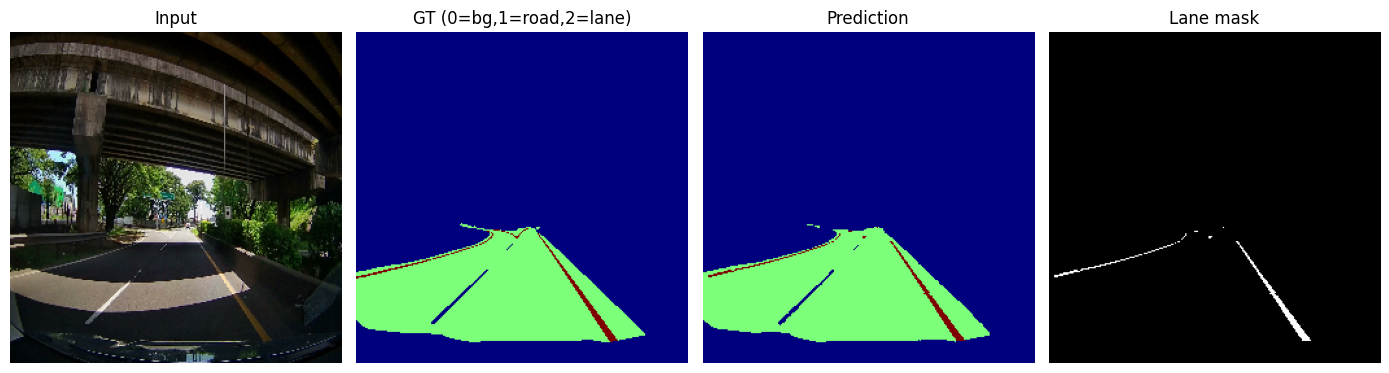

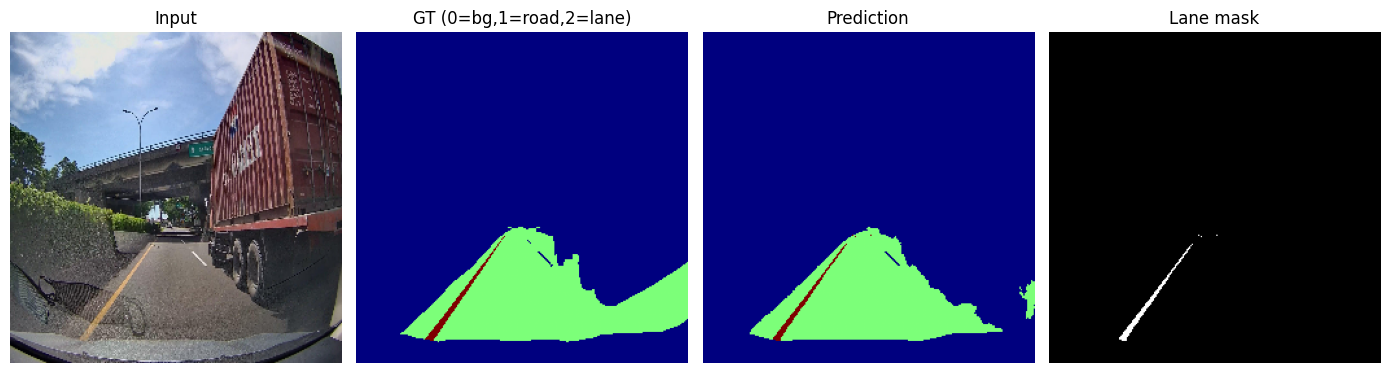

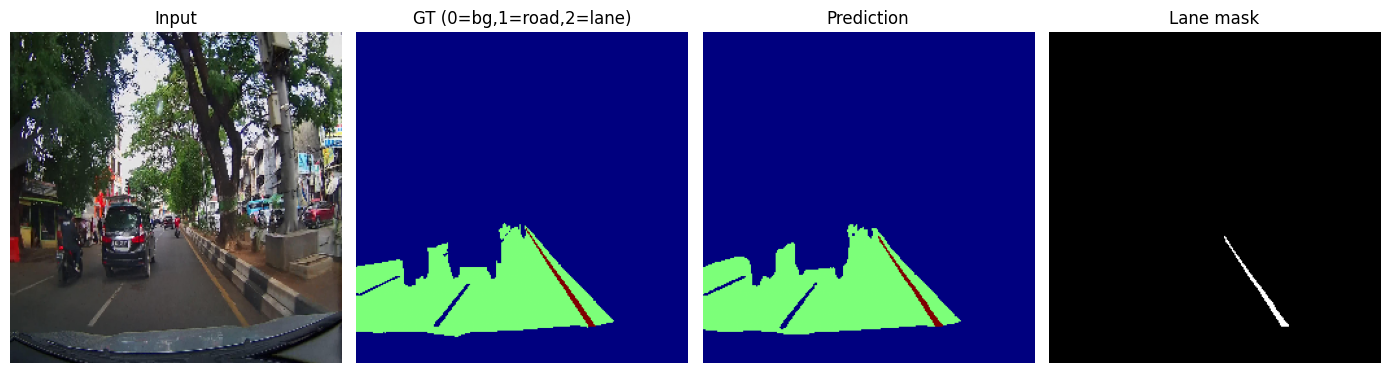

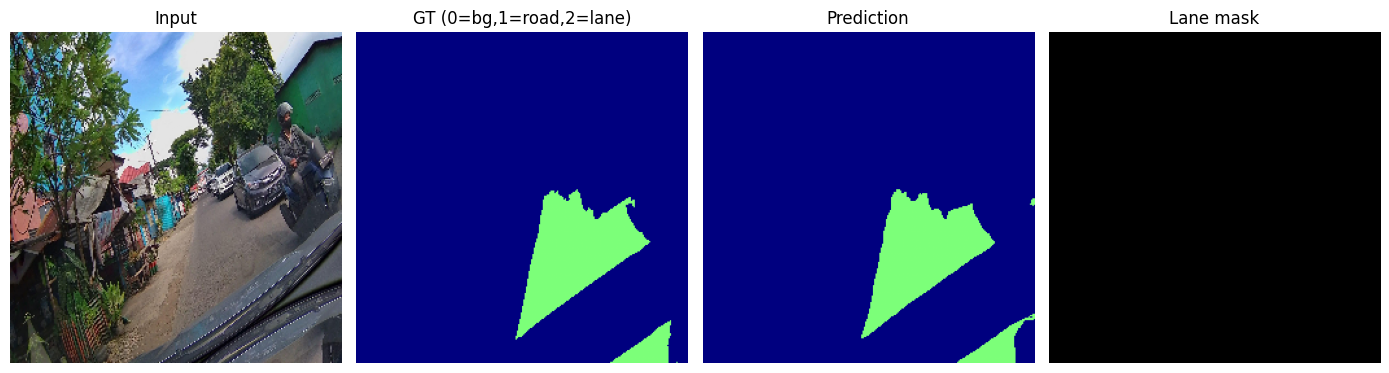

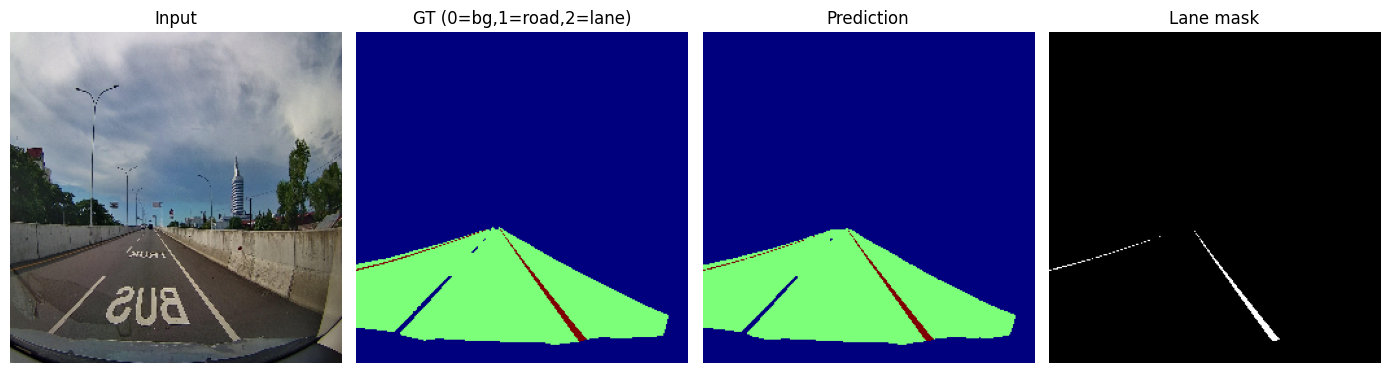

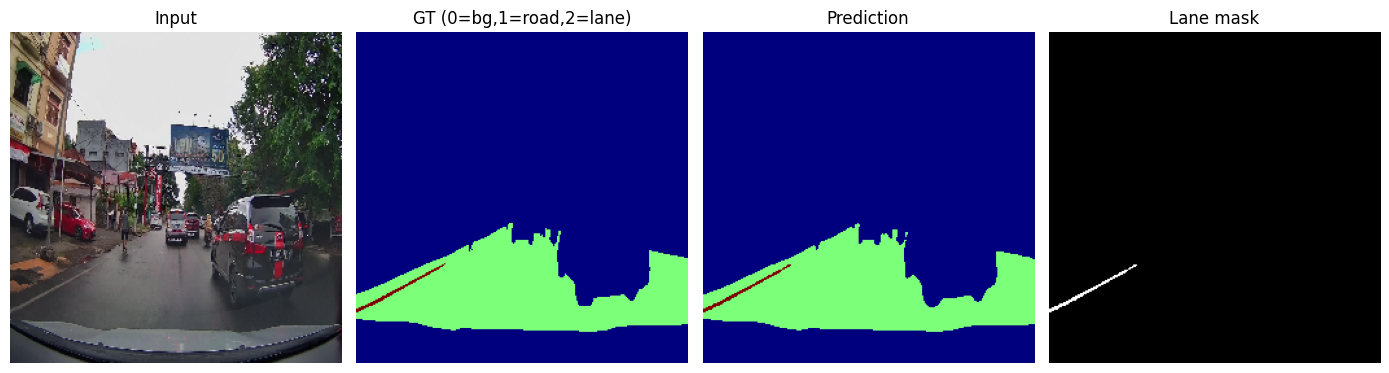

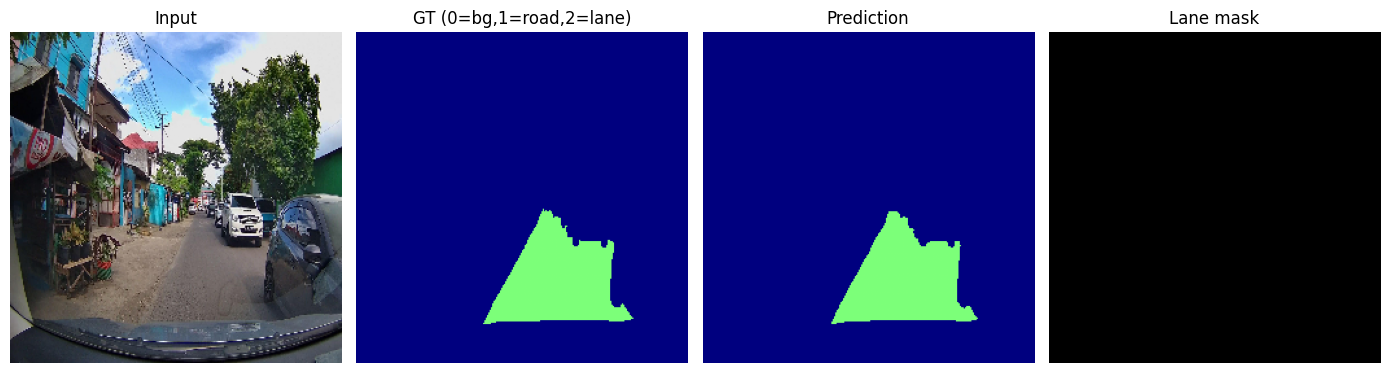

In [47]:
# threshold = 0.5
val_imgs, val_masks = next(iter(val_ds))

preds = model.predict(val_imgs)
# binary_preds = (preds > threshold).astype(np.float32)

pred_classes = np.argmax(preds, axis=-1)  # (B, H, W)

for i in range(min(10, val_imgs.shape[0])):
    plt.figure(figsize=(14, 4))

    # Input image
    plt.subplot(1, 4, 1)
    plt.imshow(val_imgs[i])
    plt.title("Input")
    plt.axis("off")

    # Ground truth (all classes)
    plt.subplot(1, 4, 2)
    plt.imshow(val_masks[i][:,:,0], cmap="jet", vmin=0, vmax=2)
    plt.title("GT (0=bg,1=road,2=lane)")
    plt.axis("off")

    # Prediction (all classes)
    plt.subplot(1, 4, 3)
    plt.imshow(pred_classes[i], cmap="jet", vmin=0, vmax=2)
    plt.title("Prediction")
    plt.axis("off")

    # Lane only (clean!)
    plt.subplot(1, 4, 4)
    plt.imshow(pred_classes[i] == 2, cmap="gray")
    plt.title("Lane mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


